# Tutorial 6: Thermohaline circulation

### Week 1, Day 2: State of the Climate - Ocean and Atmospheric Reanalysis

***
## Tutorial objectives
* Plot sea surface salinity and temperature
* Understand how salinity and temperature combine to determine ocean density
* Explore the difference between a linear and nonlinear equation of state

***
## Set up
Here we import needed packages, import ECCO data that has been preprocessed,
NOTE: Here working with interpolated data fields to lat-lon grid

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter 
import cmocean

In [2]:
#Import preprocessed ecco data. This data is surface data that is monthly over the period 2014 to 2016.
subset_theta= xr.open_dataset("surface_theta.nc")
subset_salt= xr.open_dataset("surface_salt.nc")

In [3]:
#Make land points NaN (not a number)
subset_theta=subset_theta.where(subset_theta != 0)
subset_salt=subset_salt.where(subset_salt != 0)
subset_theta=subset_theta.THETA
subset_salt=subset_salt.SALT

***
## Plot surface temperature and salinity
In the slides, we learned that in addition to the wind driven circulation, flows in the ocean can be density driven -- i.e. they happene because of gradients of density. This leads to the thermohaline circulation. Density in the ocean is made up of salinity (higher salinity = denser) and temperature (lower temperature = denser). First, let's look at the mean salinity and temperature at the surface.

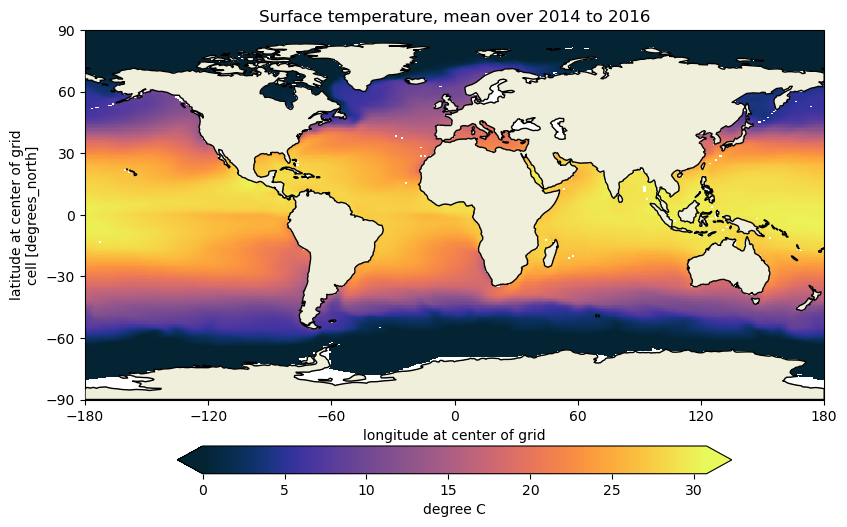

In [7]:
#Plot SST
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()},figsize=(11,12),dpi=100) #this is from cartopy https://rabernat.github.io/research_computing_2018/maps-with-cartopy.html
p=(subset_theta).plot(vmin=0,cmap=cmocean.cm.thermal,cbar_kwargs={'shrink':0.75,'orientation':'horizontal','extend':'both','pad':0.05,'label': "degree C"})
ax.coastlines(color='grey',lw=0.5)
ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
plt.title('Surface temperature, mean over 2014 to 2016')
fig.tight_layout()

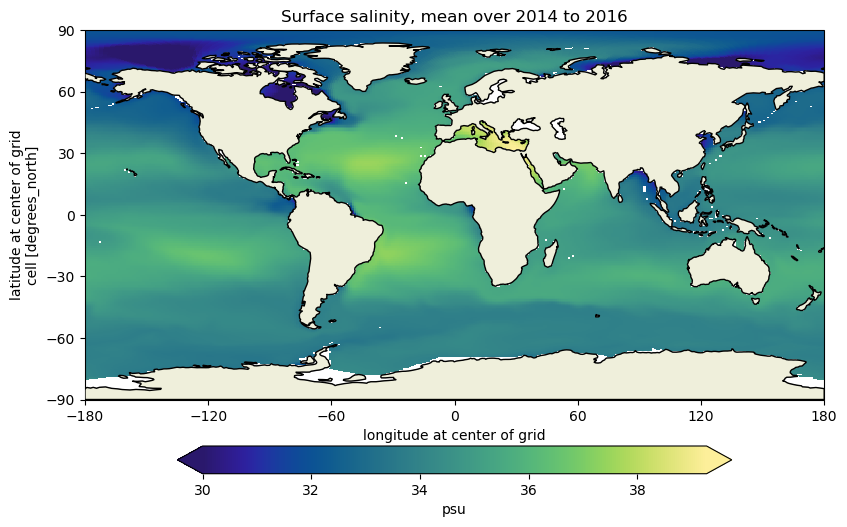

In [8]:
#Plot SSS
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()},figsize=(11,12),dpi=100) #this is from cartopy https://rabernat.github.io/research_computing_2018/maps-with-cartopy.html
p=(subset_salt).plot(cmap=cmocean.cm.haline,vmin=30,cbar_kwargs={'shrink':0.75,'orientation':'horizontal','extend':'both','pad':0.05,'label': "psu"})
ax.coastlines(color='grey',lw=0.5)
ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
plt.title('Surface salinity, mean over 2014 to 2016')
fig.tight_layout()

***
## Density from salt and temperature
The equation that describes density in the ocean is called the equation of state. It is a nonlinear function of temperature, salinity, and pressure. This can be expressed as $\rho=\rho(T,S,p)$. Here we will show two ways to calculate this. The first is a linear approximation to the equation of state. We will then show how to calculate the equation of state using the full non-linear equation using the gsw package

### Linearized equation of state
Here we take the linearized equation of state from equation 1.57 in Vallis' textbook "Atmospheric and Oceanic Fluid Dynamics"
$$ \rho=\rho_0[1-\beta_T(T-T_0)+\beta_S(S-S_0)+\beta_p(p-p_0)] $$. In this equation, $\rho_0\simeq 1027$ is a reference density, $\beta_T \simeq 2*10^{-4}$/K is the thermal expansion coefficient, $\beta_S \simeq 7.6*10^{-4}$/ppt is the haline contraction coefficient, and $\beta_p \simeq 4.4*10^{-10}$/Pa is the compressibility coeffiecient. Let's plot this assuming that the pressure at the surface is equal to the reference pressure at every point (so the $\beta_p(p-p_0)=0$). The values with $_0$ are reference values, here we choose $T_0=283$K and $S_0=35$.

The nonlinearities in the full equation arise because the $\beta$ terms themselves vary with pressure, salinity, and temperature.

In [22]:
rho=1027*(1-2E-4*(subset_theta+273.15-283)+7.6E-4*(subset_salt-35))

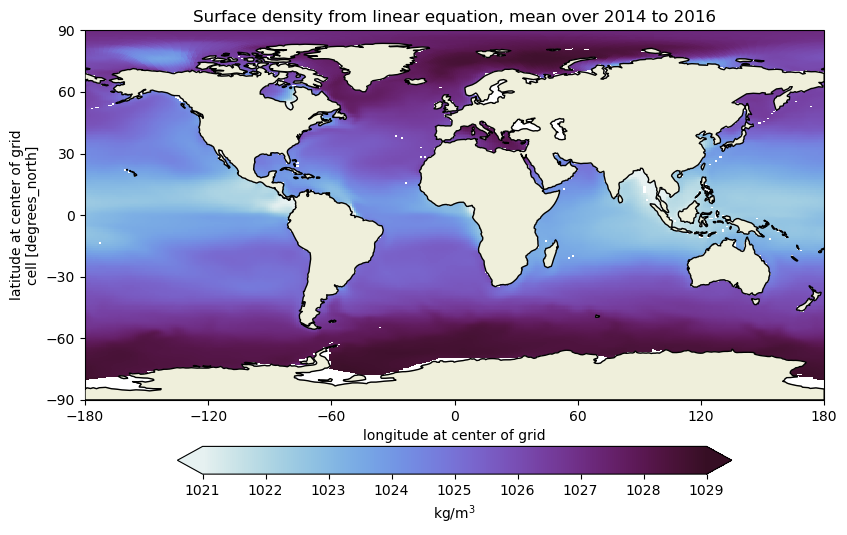

In [23]:
#Plot linearized density
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()},figsize=(11,12),dpi=100) #this is from cartopy https://rabernat.github.io/research_computing_2018/maps-with-cartopy.html
p=(rho).plot(cmap=cmocean.cm.dense,vmin=1021, vmax=1029, cbar_kwargs={'shrink':0.75,'orientation':'horizontal','extend':'both','pad':0.05,'label': "kg/m$^3$"})
ax.coastlines(color='grey',lw=0.5)
ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
plt.title('Surface density from linear equation, mean over 2014 to 2016')
fig.tight_layout()

### Full nonlinear equation 
One way to compute the density from the full nonlinear equation in python is using the gsw package which is a Python implementation of the Thermodynamic Equation of Seawater 2010 (https://teos-10.github.io/GSW-Python/)

In [24]:
import gsw
CT = gsw.CT_from_pt(subset_salt,subset_theta) #get conservative temperature from potential temperature
rho_nonlin=gsw.rho(subset_salt,CT,0)

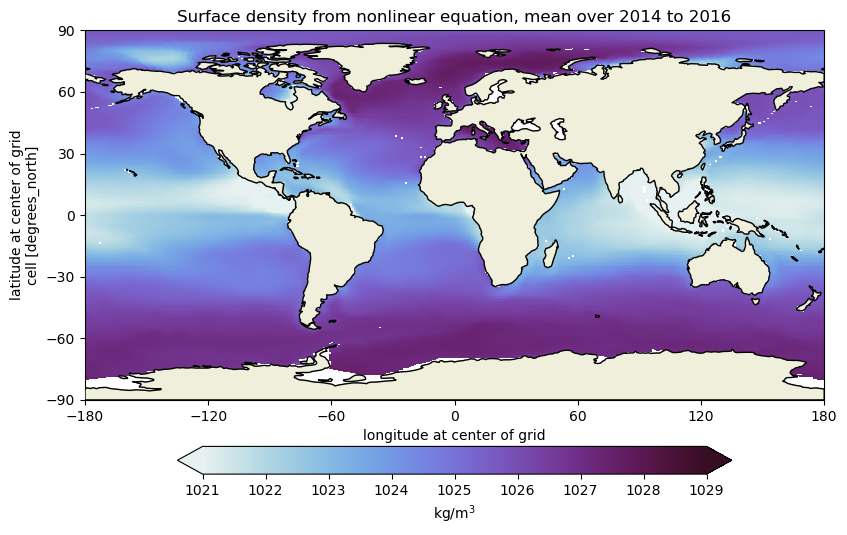

In [25]:
#Plot density from full nonlinear equation
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()},figsize=(11,12),dpi=100) #this is from cartopy https://rabernat.github.io/research_computing_2018/maps-with-cartopy.html
p=(rho_nonlin).plot(cmap=cmocean.cm.dense,vmin=1021, vmax=1029, cbar_kwargs={'shrink':0.75,'orientation':'horizontal','extend':'both','pad':0.05,'label': "kg/m$^3$"})
ax.coastlines(color='grey',lw=0.5)
ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
plt.title('Surface density from nonlinear equation, mean over 2014 to 2016')
fig.tight_layout()

We see that the two equations of state are broadly similar but there are differences - these differences are explained by the nonlinearity in the equation of state because the haline contraction coefficient and thermal expansion coefficient are not constants (as we assumed them to be for the linear equation of state). Regardless of how we calculate it though, we see that there are density differences at the surface of the ocean. The seawater tends to be less dense in the subtropics and denser near the poles for example. Thsee density differences can drive flow as discussed in the slides! 